In [1]:
! nvidia-smi

Mon Apr  8 14:42:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                      On | 00000000:00:08.0 Off |                  Off |
|  0%   43C    P0               74W / 300W|  15211MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [3]:
print_gpu_utilization()

GPU memory occupied: 15834 MB.


In [4]:
import torch

In [5]:
print_gpu_utilization()

GPU memory occupied: 15834 MB.


Creating a simple 1x1 tensor

In [6]:
torch.ones((1, 1)).to("cuda")

tensor([[1.]], device='cuda:0')

In [7]:
print_gpu_utilization()

GPU memory occupied: 16140 MB.


In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import logging
import torch
import socket
from datetime import datetime, timedelta

In [9]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [10]:
print_gpu_utilization()

GPU memory occupied: 16140 MB.


In [11]:
TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"

# Keep a max of 100,000 alloc/free events in the recorded history
# leading up to the snapshot.
MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT: int = 100000

In [12]:
logging.basicConfig(
   format="%(levelname)s:%(asctime)s %(message)s",
   level=logging.INFO,
   datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

In [13]:
def start_record_memory_history() -> None:
   if not torch.cuda.is_available():
       logger.info("CUDA unavailable. Not recording memory history")
       return

   logger.info("Starting snapshot record_memory_history")
   torch.cuda.memory._record_memory_history(
       max_entries=MAX_NUM_OF_MEM_EVENTS_PER_SNAPSHOT
   )

def stop_record_memory_history() -> None:
   if not torch.cuda.is_available():
       logger.info("CUDA unavailable. Not recording memory history")
       return

   logger.info("Stopping snapshot record_memory_history")
   torch.cuda.memory._record_memory_history(enabled=None)

def export_memory_snapshot() -> None:
   if not torch.cuda.is_available():
       logger.info("CUDA unavailable. Not exporting memory snapshot")
       return

   # Prefix for file names.
   host_name = socket.gethostname()
   timestamp = datetime.now().strftime(TIME_FORMAT_STR)
   file_prefix = f"{host_name}_{timestamp}"

   try:
       logger.info(f"Saving snapshot to local file: {file_prefix}.pickle")
       torch.cuda.memory._dump_snapshot(f"{file_prefix}.pickle")
   except Exception as e:
       logger.error(f"Failed to capture memory snapshot {e}")
       return

In [14]:
model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/pythia-1b",
    device_map="auto"
)

INFO:2024-04-08 14:42:33 We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


In [15]:
model

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-15): 16 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
  

In [16]:
model.gpt_neox.layers[0].attention.num_attention_heads

8

In [17]:
print_gpu_utilization()

GPU memory occupied: 20096 MB.


This model should approx take up 3,814.697265625 MB

In [18]:
model.get_memory_footprint() / 1024 / 1024

3939.6426391601562

the rest 700-800 MB are just CUDA Kernels and other PyTorch related kernels loaded to GPU memory!

Dummy Dataset

In [19]:
import numpy as np
from datasets import Dataset


seq_len, dataset_size = 128, 128
dummy_data = {
    "input_ids": np.random.randint(1, 30000, (dataset_size, seq_len)),
    "labels": np.random.randint(1, 30000, (dataset_size, seq_len)),
}
ds = Dataset.from_dict(dummy_data)
ds.set_format("pt")

INFO:2024-04-08 14:42:35 PyTorch version 2.1.0+cu118 available.


In [20]:
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
    "dataloader_pin_memory": False,
    "optim": "adamw_torch"
}

Optimizer Supported: https://github.com/huggingface/transformers/blob/main/src/transformers/training_args.py#L133

In [21]:
model.train()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-15): 16 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
  

In [22]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [23]:
print_trainable_parameters(model)

trainable params: 1011781632 || all params: 1011781632 || trainable%: 100.0


In [24]:
from transformers import TrainingArguments, Trainer

# logging.set_verbosity_error()


training_args = TrainingArguments(per_device_train_batch_size=24, fp16=False, **default_args)
trainer = Trainer(model=model, args=training_args, train_dataset=ds)
start_record_memory_history()
result = trainer.train()
export_memory_snapshot()
stop_record_memory_history()
print_summary(result)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
INFO:2024-04-08 14:42:35 Starting snapshot record_memory_history


Step,Training Loss,Validation Loss


INFO:2024-04-08 14:42:41 Saving snapshot to local file: 970442700e99_Apr_08_14_42_41.pickle
INFO:2024-04-08 14:42:43 Stopping snapshot record_memory_history


Time: 5.67
Samples/second: 22.58
GPU memory occupied: 40974 MB.


In [25]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated() / 1024 / 1024)

11681.18798828125


That climbed to 13.7GB!

4GB Model + 8GB Optimizer + 4GB Gradients

In [26]:
24 - (4+8+4)*1.1 - 2 # remaining GPU (2GB used by kernels and display, 10% is overhead)

4.399999999999999

In [27]:
24 - (4+8+4)*1.1 - 2 # remaining GPU (2GB used by kernels and display, 10% is overhead)

4.399999999999999

In [28]:
BS = 24
128 * BS * 2048 * 16 * (34 + (5*8*128)/2048) / 1024 / 1024 / 1024 / 2

1.7109375

- BS 32 will not work with defaults

per_device_train_batch_size=32


- BS 24 works

per_device_train_batch_size=34

- BS 32 works with gradient checkpointing

per_device_train_batch_size=32, gradient_checkpointing=True

- BS 32 with GC and GA

per_device_train_batch_size=32, gradient_accumulation_steps=4, gradient_checkpointing=True

Effectively the BS becomes BS * GA = 32 * 4 = 128

- BS 32 with FP16

per_device_train_batch_size=32, fp16=True

Activations are reduced by half! So we can push to BS=48 Now

Also Training becomes much faster!

In [29]:
total_parameters = 0

for param_group in trainer.optimizer.optimizer.state_dict()['state'].values():
    for param_tensor in param_group.values():
        total_parameters += param_tensor.numel()

print("Total parameters in the optimizer state: {}".format(total_parameters))


Total parameters in the optimizer state: 2023563460


In [30]:
torch.cuda.empty_cache()

In [31]:
print_summary(result)

Time: 5.67
Samples/second: 22.58
GPU memory occupied: 29100 MB.


In [32]:
torch.cuda.memory_allocated() / 1024 / 1024

11681.18798828125

Memory Profiler

In [33]:
from torch.autograd.profiler import record_function
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import TrainingArguments, Trainer
import inspect
import logging
import torch
import socket
from datetime import datetime, timedelta
import weakref
from functools import wraps

In [34]:
model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/pythia-1b",
    device_map="auto"
)

INFO:2024-04-08 14:42:43 We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


In [35]:
logging.basicConfig(
   format="%(levelname)s:%(asctime)s %(message)s",
   level=logging.INFO,
   datefmt="%Y-%m-%d %H:%M:%S",
)
logger: logging.Logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

TIME_FORMAT_STR: str = "%b_%d_%H_%M_%S"

In [36]:
def trace_handler(prof: torch.profiler.profile):
   # Prefix for file names.
   host_name = socket.gethostname()
   timestamp = datetime.now().strftime(TIME_FORMAT_STR)
   file_prefix = f"{host_name}_{timestamp}"

   # Construct the trace file.
   prof.export_chrome_trace(f"{file_prefix}.json.gz")

   # Construct the memory timeline file.
   prof.export_memory_timeline(f"{file_prefix}.html", device="cuda:0")


In [37]:
import numpy as np
from datasets import Dataset


seq_len, dataset_size = 128, 128
dummy_data = {
    "input_ids": np.random.randint(1, 30000, (dataset_size, seq_len)),
    "labels": np.random.randint(1, 30000, (dataset_size, seq_len)),
}
ds = Dataset.from_dict(dummy_data)
ds.set_format("pt")

In [38]:
default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
    "dataloader_pin_memory": False,
    "optim": "adamw_torch"
}

In [39]:
model.train()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-15): 16 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
  

In [40]:
training_args = TrainingArguments(per_device_train_batch_size=24, fp16=False, **default_args)
trainer = Trainer(model=model, args=training_args, train_dataset=ds)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [41]:
# # Original forward pass methoda
# original_forward = model.forward

# # New forward pass method with record_function
# def new_forward(*args, **kwargs):
#     print(args, "\n", kwargs)
#     with record_function("## forward ##"):
#         return original_forward(*args, **kwargs)

# # Patch the model's forward method
# model.forward = new_forward

# Patch the accelerator's backward method
original_backward = trainer.accelerator.backward

def new_backward(*args, **kwargs):
    with record_function("## backward ##"):
        return original_backward(*args, **kwargs)

trainer.accelerator.backward = new_backward

# Patch the optimizer's step method
optimizer = trainer.create_optimizer()
original_step = optimizer.step

def new_step(*args, **kwargs):
    with record_function("## optimizer step ##"):
        return original_step(*args, **kwargs)

new_step.__func__ = original_step.__func__
new_step.__self__ = original_step.__self__
optimizer.step = new_step

/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:339: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")
STAGE:2024-04-08 14:42:45 1177:1177 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


{'train_runtime': 5.6621, 'train_samples_per_second': 22.607, 'train_steps_per_second': 1.06, 'train_loss': 11.262858072916666, 'epoch': 1.0}


STAGE:2024-04-08 14:42:51 1177:1177 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-04-08 14:42:51 1177:1177 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
INFO:2024-04-08 14:43:26 generated new fontManager


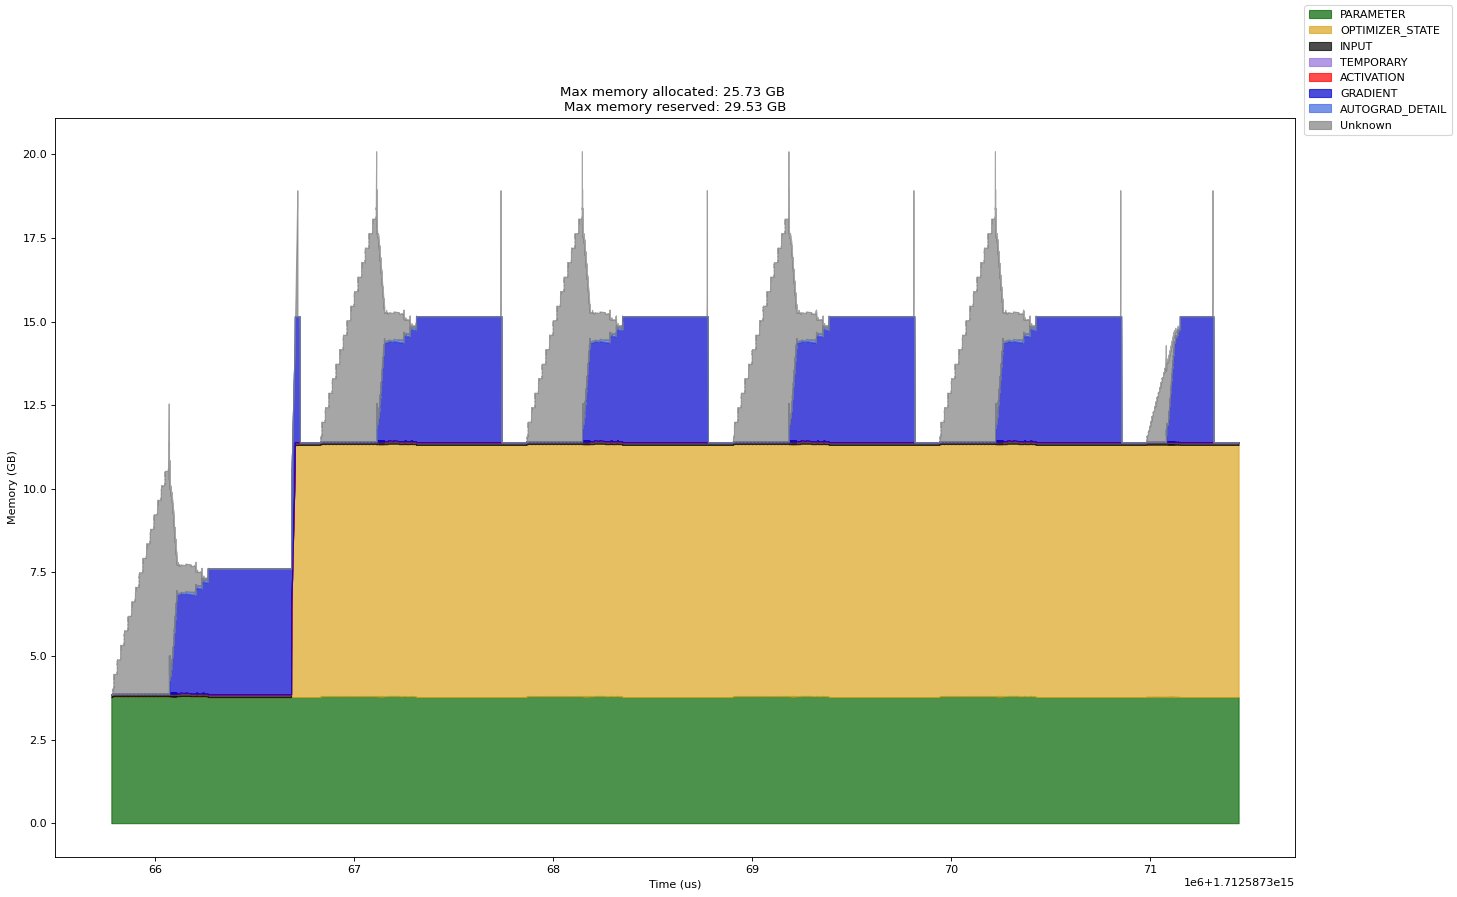

In [42]:
with torch.profiler.profile(
       activities=[
           torch.profiler.ProfilerActivity.CPU,
           torch.profiler.ProfilerActivity.CUDA,
       ],
       schedule=torch.profiler.schedule(wait=0, warmup=0, active=6, repeat=1),
       record_shapes=True,
       profile_memory=True,
       with_stack=True,
       on_trace_ready=trace_handler,
   ) as prof:
    result = trainer.train()

In [43]:
import torch

# Call this function after running your model on the GPU
print(torch.cuda.memory_summary(device=None, abbreviated=False))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  15622 MiB |  24537 MiB | 468961 MiB | 453338 MiB |
|       from large pool |  15584 MiB |  24497 MiB | 467962 MiB | 452378 MiB |
|       from small pool |     38 MiB |     41 MiB |    998 MiB |    960 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  15622 MiB |  24537 MiB | 468961 MiB | 453338 MiB |
|       from large pool |  15584 MiB |  24497 MiB | 467962 MiB |